In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import os
#os.getcwd()
os.chdir('/Users/Grant/Documents/Model Risk Mgmt/')
import warnings
warnings.filterwarnings('ignore')


**Your code below**

*   Reduce the overall data set to 200K rows or less
*   Split your data for training / testing
*   Build at least two models with `loan_status` as the target
*   Report on the model's performance
*   Report on the model's drivers (feature importance / effects)

Plant 2 flaws in this notebook.  Do not "give away" the answers here.  This notebook should appear, at first glance, to create a viable model.

Make a note of your flaws and be prepared to talk about how the code / results look when they are "fixed".  You will need to talk about those in the final presentation.

In [2]:
loan_df = pd.read_pickle('clean_df_for_eda.pkl')

In [3]:
loan_df.fully_paid.value_counts(normalize = True)

1    0.796288
0    0.203712
Name: fully_paid, dtype: float64

In [4]:
subset_size = 200000

# Calculate the sample size for each category in the target column
proportions = loan_df['fully_paid'].value_counts(normalize=True)
sample_sizes = (proportions * subset_size).round().astype(int)

# Perform stratified sampling on the target column
loan_df = (
    loan_df.groupby('fully_paid', group_keys=False)
    .apply(lambda group: group.sample(n=sample_sizes[group.name], random_state=42))
)

loan_df.fully_paid.value_counts(normalize = True)

1    0.79629
0    0.20371
Name: fully_paid, dtype: float64

In [5]:
num_cols = loan_df.select_dtypes(include=['float64'])

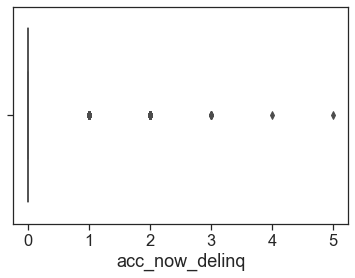

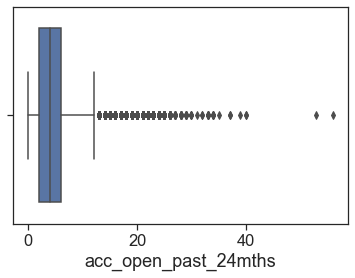

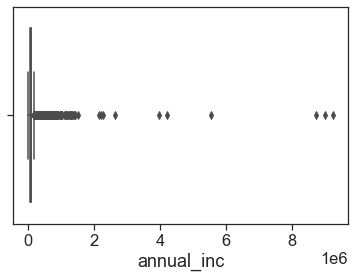

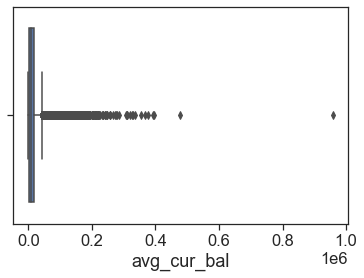

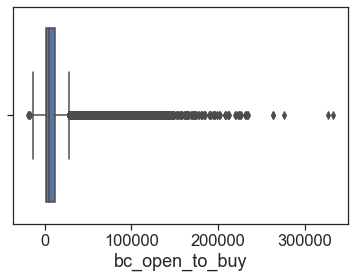

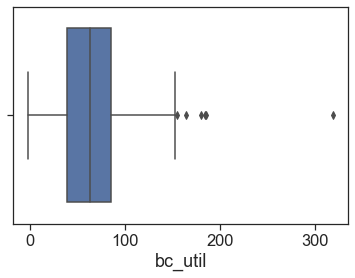

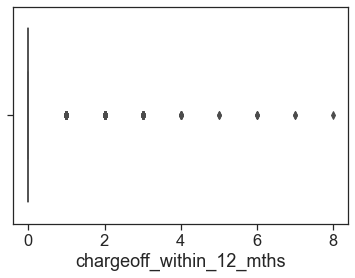

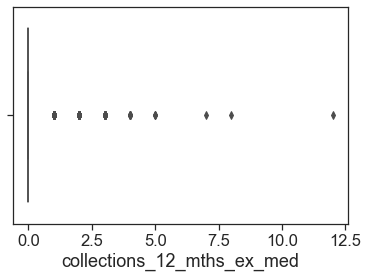

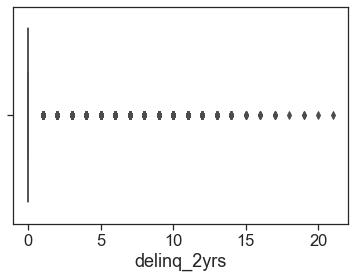

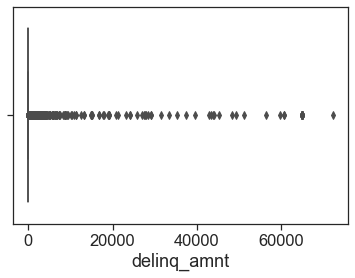

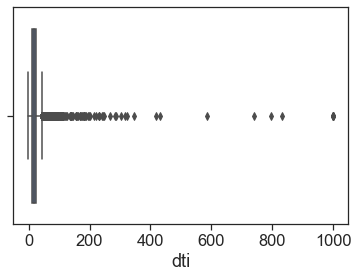

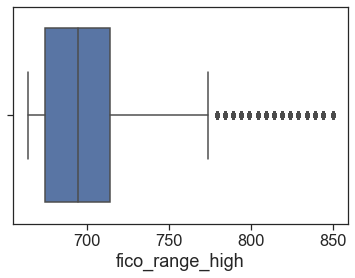

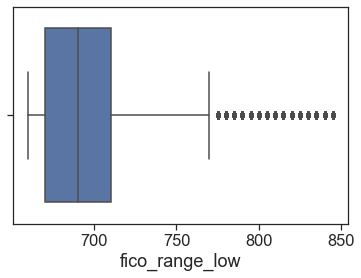

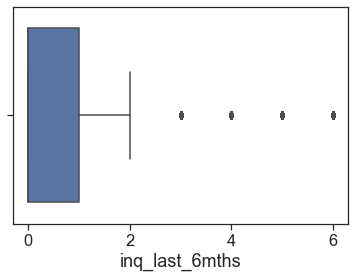

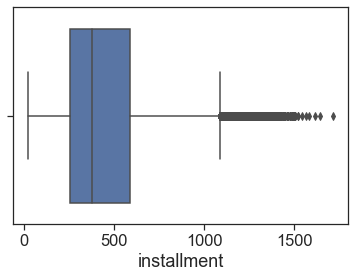

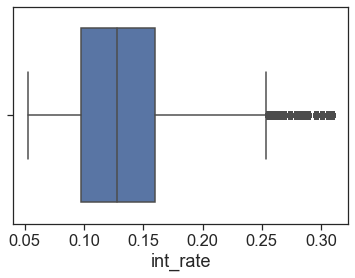

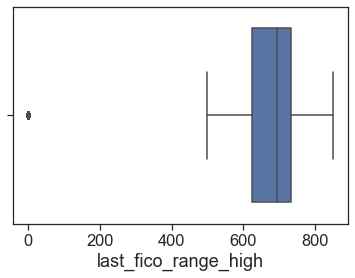

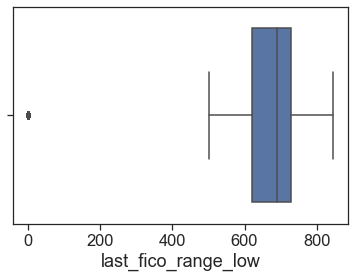

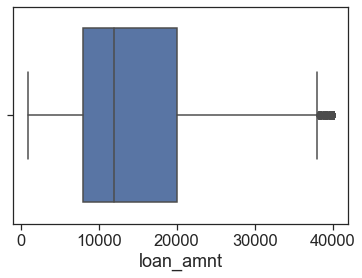

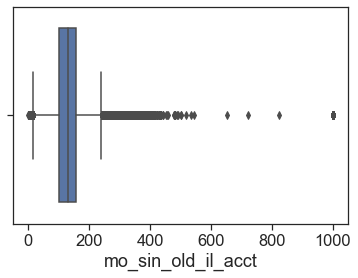

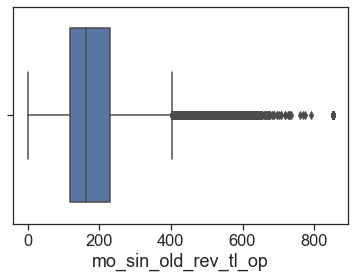

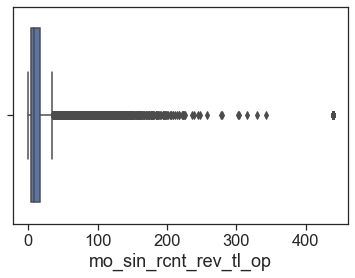

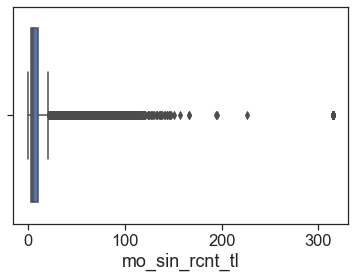

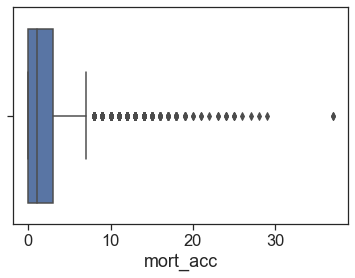

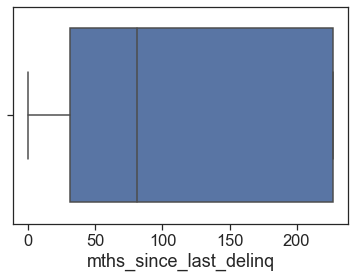

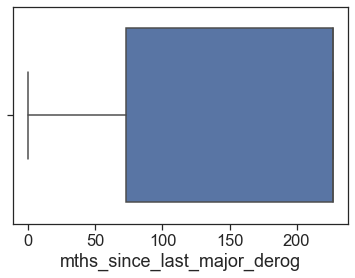

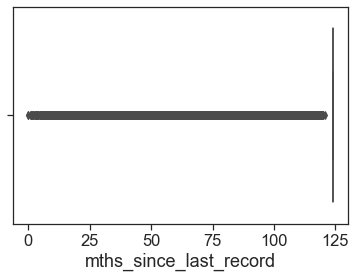

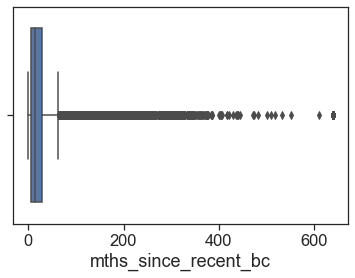

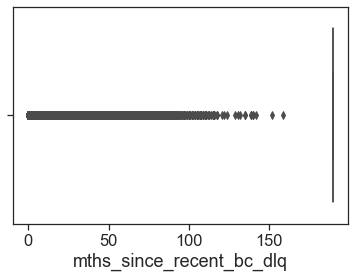

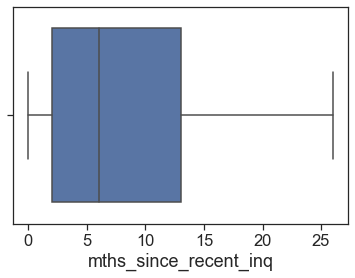

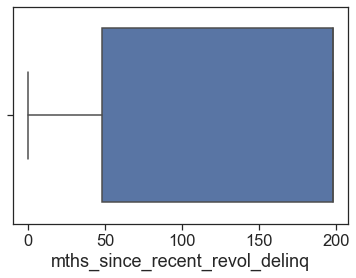

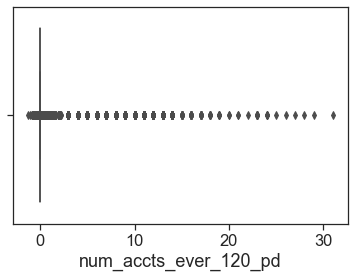

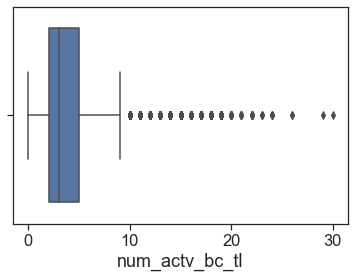

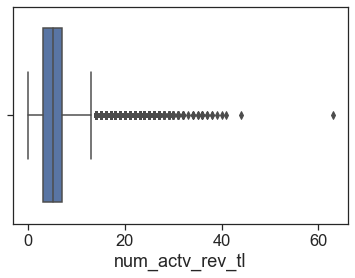

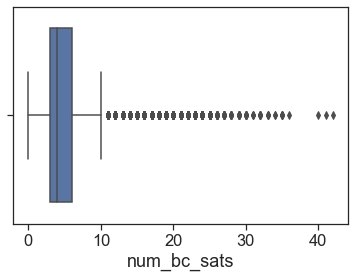

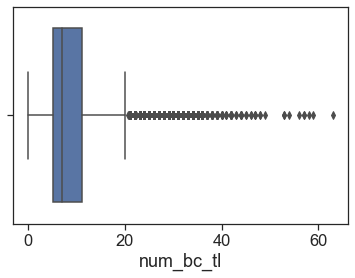

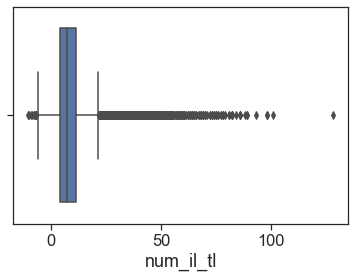

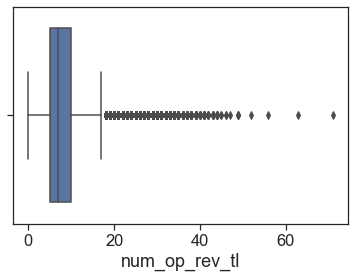

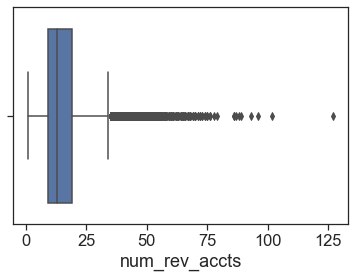

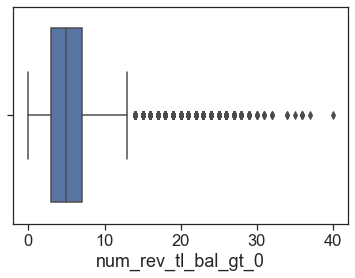

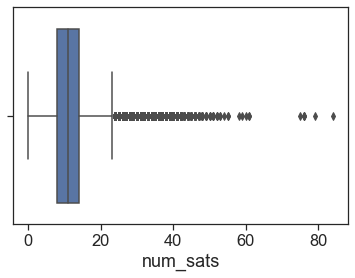

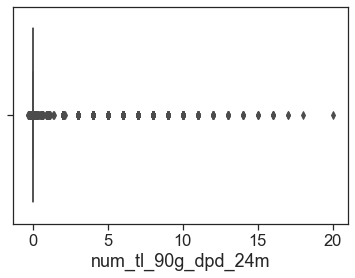

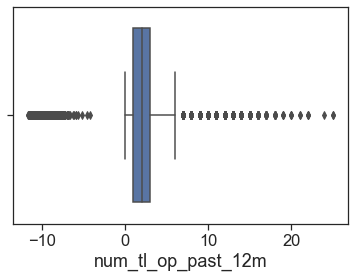

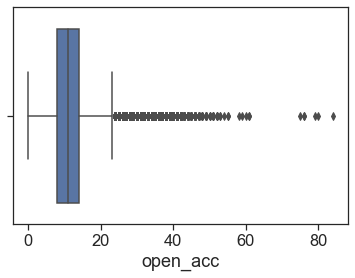

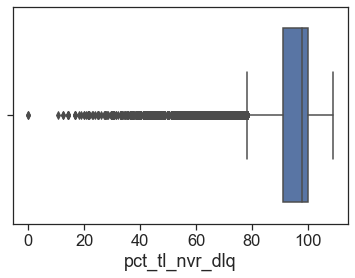

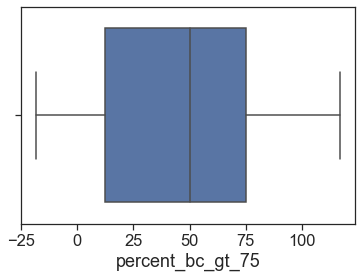

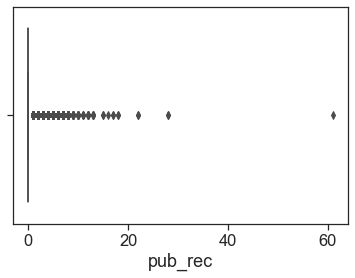

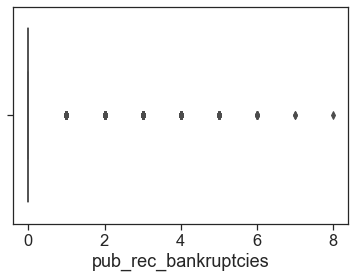

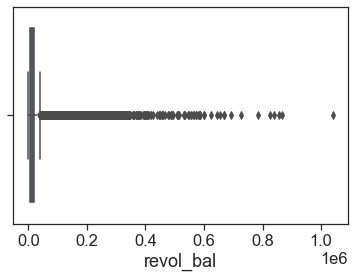

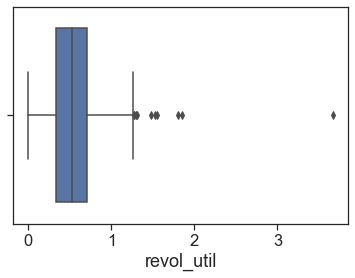

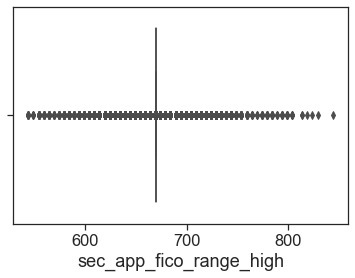

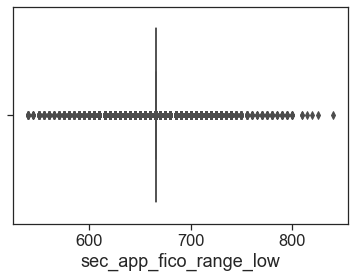

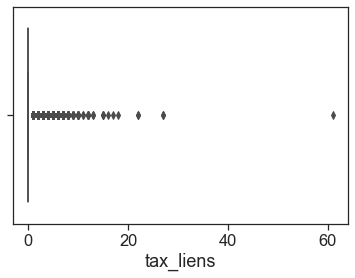

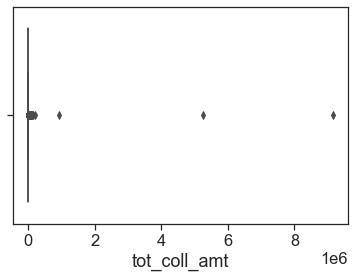

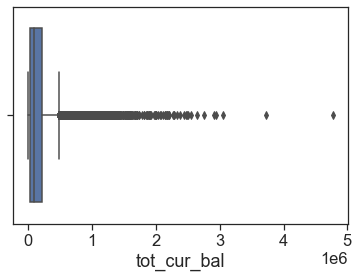

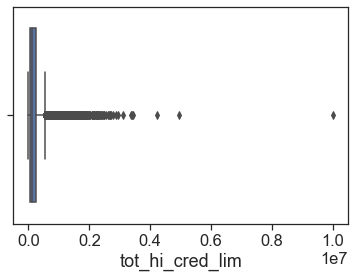

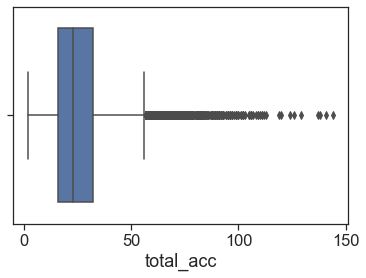

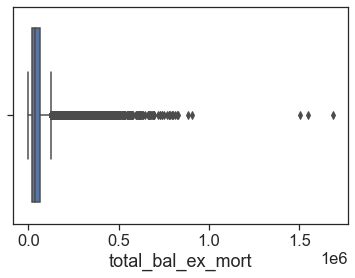

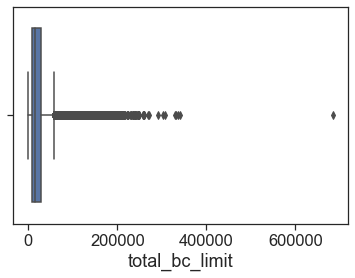

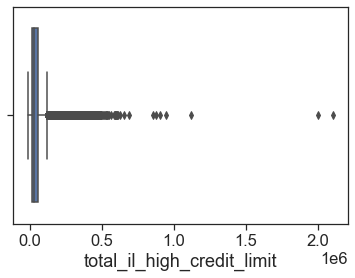

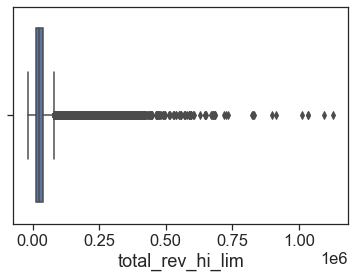

In [6]:
for col in num_cols:
    sns.boxplot(data = loan_df, x = col)
    plt.show()

In [7]:
from scipy.stats import zscore
# Calculate Z-scores
z_scores = num_cols.apply(zscore)

# Filter out rows with any Z-scores > 3 or < -3
num_cols_no_outliers = num_cols[(z_scores < 3).all(axis=1)]
df_no_outliers = pd.concat([num_cols_no_outliers, loan_df.drop(columns=num_cols.columns)], axis=1)
df_no_outliers.dropna(inplace = True)

In [8]:
loan_df.shape

(200000, 99)

In [9]:
df_no_outliers.shape

(140910, 99)

In [18]:
df_no_outliers['year']=df_no_outliers['issue_d'].dt.year
df_no_outliers['month']=df_no_outliers['issue_d'].dt.month

In [31]:
df_no_outliers['addr_state']=df_no_outliers['addr_state'].astype('category')
df_no_outliers['application_type']=df_no_outliers['application_type'].astype('category')
df_no_outliers['emp_length']=df_no_outliers['emp_length'].astype('category')
df_no_outliers['home_ownership']=df_no_outliers['home_ownership'].astype('category')
df_no_outliers['purpose']=df_no_outliers['purpose'].astype('category')
df_no_outliers['verification_status']=df_no_outliers['verification_status'].astype('category')
df_no_outliers['term']=df_no_outliers['term'].astype('category')

In [32]:
df_no_outliers.dtypes

acc_now_delinq           float64
acc_open_past_24mths     float64
annual_inc               float64
avg_cur_bal              float64
bc_open_to_buy           float64
                          ...   
purpose                 category
term                    category
verification_status     category
year                       int64
month                      int64
Length: 101, dtype: object

In [10]:
sorted(df_no_outliers.columns)

['acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'annual_inc',
 'application_type',
 'application_type_Joint App',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'credit_line_age',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'emp_length',
 'emp_length_10+ years',
 'emp_length_2-4 years',
 'emp_length_5-9 years',
 'fico_range_high',
 'fico_range_low',
 'fully_paid',
 'grade',
 'home_ownership',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_re

In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [36]:
model_df = df_no_outliers.copy()
X = model_df.drop(columns = ['grade','sub_grade','fully_paid','installment','int_rate','zip_code','issue_d'])
y = model_df['fully_paid']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.25, random_state=42)

In [58]:
import optuna
import lightgbm as lgb
import sklearn.metrics

from sklearn.model_selection import train_test_split

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    data, target = X,y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25, stratify=target)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    recall = sklearn.metrics.recall_score(valid_y, pred_labels)
    return accuracy, recall

In [59]:
y.value_counts()

1    112445
0     28465
Name: fully_paid, dtype: int64

In [60]:
study = optuna.create_study(directions=['maximize','maximize'])
study.optimize(objective, n_trials=100)

[I 2024-11-17 15:21:29,908] A new study created in memory with name: no-name-a94d80e1-4b33-469c-b455-76c5454ed7dc
[I 2024-11-17 15:21:31,300] Trial 0 finished with values: [0.9166004314749631, 0.9491676152532726] and parameters: {'lambda_l1': 0.16484557250015552, 'lambda_l2': 5.5849920706208565, 'num_leaves': 15, 'feature_fraction': 0.7835685434945464, 'bagging_fraction': 0.7151898865204445, 'bagging_freq': 7, 'min_child_samples': 5}.
[I 2024-11-17 15:21:32,356] Trial 1 finished with values: [0.9136766208697626, 0.9479225953329539] and parameters: {'lambda_l1': 7.173437301938703e-06, 'lambda_l2': 9.770478411613642e-07, 'num_leaves': 19, 'feature_fraction': 0.8563924366922613, 'bagging_fraction': 0.46209883425636816, 'bagging_freq': 3, 'min_child_samples': 18}.
[I 2024-11-17 15:21:34,353] Trial 2 finished with values: [0.9123708413761781, 0.9459661354581673] and parameters: {'lambda_l1': 9.248260828432007e-07, 'lambda_l2': 0.19022414548348365, 'num_leaves': 117, 'feature_fraction': 0.62

In [61]:
study.best_trials

[FrozenTrial(number=24, state=TrialState.COMPLETE, values=[0.9172533212217554, 0.9486696072851452], datetime_start=datetime.datetime(2024, 11, 17, 15, 22, 16, 391987), datetime_complete=datetime.datetime(2024, 11, 17, 15, 22, 17, 868904), params={'lambda_l1': 7.653305665350621e-08, 'lambda_l2': 0.0826708445755796, 'num_leaves': 51, 'feature_fraction': 0.8763393461837459, 'bagging_fraction': 0.6900211412576689, 'bagging_freq': 7, 'min_child_samples': 27}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'min_

In [62]:
trial = optuna.trial.Trial(study,45)

In [63]:
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Params: 
    lambda_l1: 1.4093746514830682e-07
    lambda_l2: 5.258998185678545e-07
    num_leaves: 204
    feature_fraction: 0.6600077162526377
    bagging_fraction: 0.9802010400709571
    bagging_freq: 5
    min_child_samples: 89


In [50]:
params = trial.params

Training accuracy 0.9684
Testing accuracy 0.9162


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

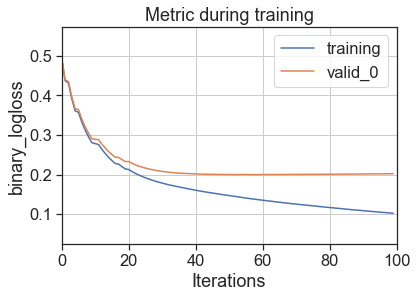

In [68]:
lgbm = lgb.LGBMClassifier(lambda_l1= 1.4093746514830682e-07,
    lambda_l2= 5.258998185678545e-07,
    num_leaves= 204,
    feature_fraction= 0.6600077162526377,
    bagging_fraction= 0.9802010400709571,
    bagging_freq= 5,
    min_child_samples= 89)
lgbm.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])
print('Training accuracy {:.4f}'.format(lgbm.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgbm.score(X_test,y_test)))
lgb.plot_metric(lgbm)

In [69]:
lgbm = lgb.LGBMClassifier(lambda_l1= 0.013291314585684007,
    lambda_l2= 0.0021574229713529607,
    num_leaves= 22,
    feature_fraction= 0.9291348308588118,
    bagging_fraction= 0.7043465256980788,
    bagging_freq= 3,
    min_child_samples= 99
)
lgbm.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])


LGBMClassifier(bagging_fraction=0.7043465256980788, bagging_freq=3,
               feature_fraction=0.9291348308588118,
               lambda_l1=0.013291314585684007, lambda_l2=0.0021574229713529607,
               min_child_samples=99, num_leaves=22)

In [70]:
print('Training accuracy {:.4f}'.format(lgbm.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgbm.score(X_test,y_test)))

Training accuracy 0.9236
Testing accuracy 0.9172


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

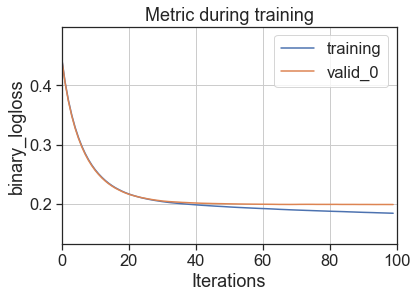

In [71]:
lgb.plot_metric(lgbm)